This file is part of GaPSE
Copyright (C) 2022 Matteo Foglieni

GaPSE is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

GaPSE is distributed in the hope that it will be useful, but
WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the GNU
General Public License for more details.

You should have received a copy of the GNU General Public License
along with GaPSE. If not, see <http://www.gnu.org/licenses/>.
```


```

In [122]:
PATH_TO_FFTLog = "../../FFTLog.jl/";

In [123]:
include(PATH_TO_FFTLog * "src/FFTLog.jl");

┌ Info: Precompiling Nemo [2edaba10-b0f1-5616-af89-8c11ac63239a]
└ @ Base loading.jl:1423



Welcome to Nemo version building

Nemo comes with absolutely no warranty whatsoever



In [1]:
maximum_comoving_distance = 1.389556413208e+04;

In [2]:
max_co_dist_for_survey = 1.389556413208e+04/3

4631.854710693334

In [3]:
corr_max_redshift_for_survey = 1.663683173266e+00

1.663683173266

# Effective 𝑓_NL

This ipynb provides the code necessary to compute the effective factor of Non-Linear effects $\mathit{f}_{\rm NL}$.

All the output files will be placed in the following directory:

In [4]:
DIR = "Effective_fNL_z115_files/";

## Basic Framework

In [6]:
PATH_TO_GAPSE = "../";

In [7]:
include(PATH_TO_GAPSE * "src/GaPSE.jl");

In [62]:
using DelimitedFiles, Plots, Dierckx, SpecialFunctions
using Printf, LaTeXStrings, Turing, StatsPlots, GridInterpolations

In [89]:
#z_min, z_max, θ_max = 0.05, 0.20, π / 2.0
z_min, z_max, θ_max = 1.0, 1.5, π / 2.0

WFI_opts = Dict(
    :ss_start => 100, :ss_stop => 6000, 
    :ss_step => 50, :llim => 0.0, :rlim => Inf, 
    :rtol => 5e-2, :atol => 0.0, :N => 1000, #:pr => true,
)

FILE_F_MAP = PATH_TO_GAPSE * "data/F_REFERENCE_pi2.txt"
FILE_PS = PATH_TO_GAPSE * "test/datatest/file_pk.txt"
FILE_BACKGROUND = PATH_TO_GAPSE * "test/datatest/WideA_ZA_background.dat"

params = GaPSE.CosmoParams(z_min, z_max, θ_max;
    Ω_b = 0.0489, Ω_cdm = 0.251020, h_0 = 0.70, s_lim=1e-2,
    s_b = 0.0, 𝑓_evo = 0.0, b = 1.0,
    IPS_opts = Dict(
        :fit_left_min => 1e-6, :fit_left_max => 3e-6,
        :fit_right_min => 1e1, :fit_right_max => 2e1),
    IPSTools_opts = Dict(
        :N => 1024, :fit_min => 0.05, :fit_max => 0.5, 
        :con => true, :k_min => 1e-8, :k_max => 10.0),
    WFI_opts = WFI_opts,
);

In [90]:
new_calc_μs = union([μ for μ in -1.0:0.01:(-0.9)], 
        [μ for μ in -0.9:0.05:0.9], 
        [μ for μ in 0.9:0.01:1.0]);
FILE_IF_MAP = PATH_TO_GAPSE*"data/IntF_pi2_z115.txt"

GaPSE.print_map_IntegratedF(
    FILE_F_MAP, FILE_IF_MAP, 
    z_min, z_max, new_calc_μs, FILE_BACKGROUND;
    trap = true, WFI_opts...
)

calculating intF: 100%|█████████████████████████████████| Time: 0:01:20


In [91]:
cosmo = GaPSE.Cosmology(params, FILE_BACKGROUND, FILE_PS, FILE_F_MAP, FILE_IF_MAP);

GaPSE.parameters_used(stdout, cosmo)

###############
#    GaPSE    #
############### 
#
# The Cosmology considered had the following paremeters:
# 
# - Matter Power Spectrum input file: "../test/datatest/file_pk.txt"
# - Background data input file: "../test/datatest/WideA_ZA_background.dat"
# - F window function input file: "../data/F_REFERENCE_pi2.txt"
# - Integrated F window function input file: "../data/IntF_pi2_z115.txt"
#
# - Basic CosmoParams considered: 
#	 z_min = 1.0 	 z_max = 1.5
#	 θ_max = 1.5707963267948966 [rad] 	 h_0 = 0.7
#	 Ω_b = 0.0489 	 Ω_cdm = 0.25102 	 Ω_M0 = 0.29992
#	 b = 1.0 	 f_evo = 0.0 	 s_b = 0.0
#
# - CosmoParams about the Input Power Spectrum: 
#	 fit_left_min = 1.0e-6 	 fit_right_min = 10.0 	 
#	 fit_left_max = 3.0e-6 	 fit_right_max = 20.0 	 
#
# - CosmoParams about the Input Power Spectrum Tools: 
#	 k_max = 10.0 	 fit_max = 0.5 	 N = 1024 	 
#	 con = true 	 k_min = 1.0e-8 	 fit_min = 0.05 	 
#
# - CosmoParams about the Integrated Window Function F: 
#	 ss_step = 50 	 N = 1000 	 rtol = 0.05

## Check window function F an integrated IF

In [92]:
my_matrix = readdlm(FILE_F_MAP, comments=true)
my_xs = convert(Vector{Float64}, my_matrix[:,1])
my_μs = convert(Vector{Float64}, my_matrix[:,2])
my_Fs = convert(Vector{Float64}, my_matrix[:,3]);
my_F_grid = GridInterpolations.RectangleGrid( unique(my_μs), unique(my_xs))
my_spline_F(x, μ) = GridInterpolations.interpolate(my_F_grid, my_Fs, [μ, x]);

In [93]:
my_Imatrix = readdlm(FILE_IF_MAP, comments=true)
my_Iss = convert(Vector{Float64}, my_Imatrix[:,1])
my_Iμs = convert(Vector{Float64}, my_Imatrix[:,2])
my_IFs = convert(Vector{Float64}, my_Imatrix[:,3]);
my_IF_grid = GridInterpolations.RectangleGrid( unique(my_Iμs), unique(my_Iss))
my_spline_IF(s, μ) = GridInterpolations.interpolate(my_IF_grid, my_IFs, [μ, s]);

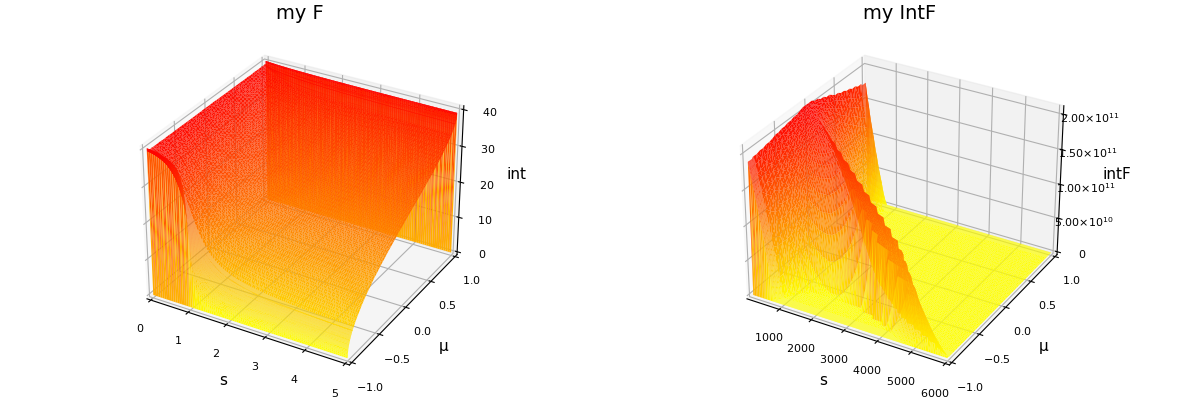

In [94]:
p1 = plot(my_xs, my_μs, my_Fs; xl="s", yl="μ", zl="int", 
    st = :surface, c=cgrad([:yellow, :red]), size=(600, 300), 
    title="my F", legend = false)
p2 = plot(my_Iss, my_Iμs, my_IFs; xl="s", yl="μ", zl="intF", 
    st = :surface, c=cgrad([:yellow, :red]), size=(600, 300), 
    title="my IntF", legend = false)
plot(p1, p2, size=(1200, 400))

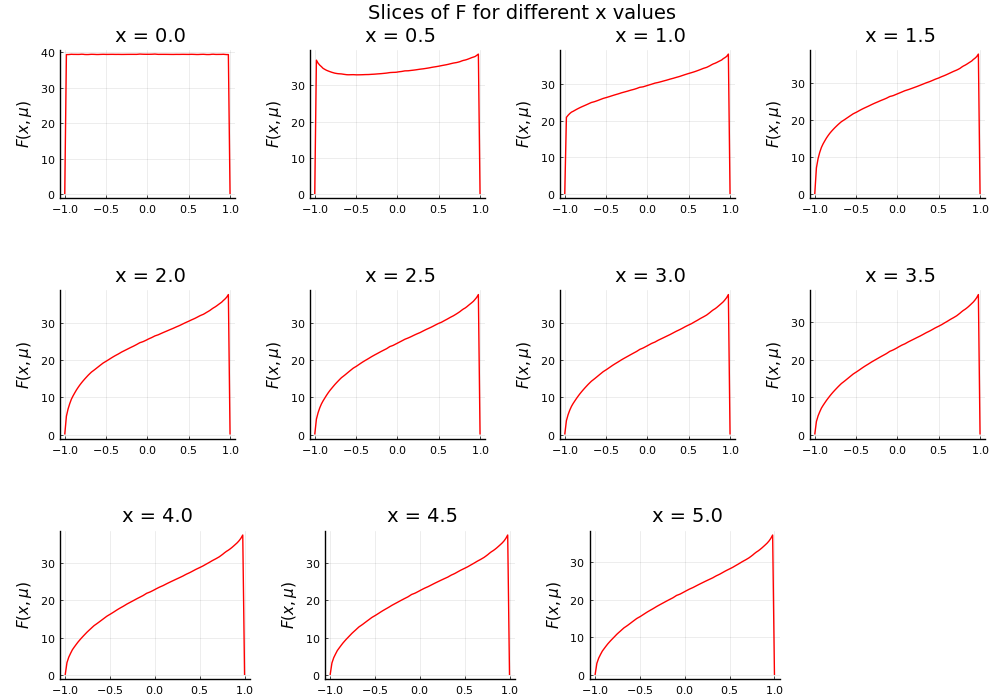

In [95]:
pyplot()

title = plot(title = "Slices of F for different x values", grid=false, 
    showaxis = false, bottom_margin = -50Plots.px, ticks=false)

θ_max =  π/2.0;
xs = [0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0];
μs = range(-1.0, 1.0, length=100);

LIST_P = [plot() for i in 1:length(xs)]
for (i,x) in enumerate(xs)
    tit = "\n\n x = $x"
    xs_1 = μs
    ys_1 = [my_spline_F(x, μ) for μ in xs_1]

    LIST_P[i] = plot(xs_1, ys_1, 
        #xaxis=:log, yaxis=:log, 
        lc=:red, title=tit, legend=false,
        ylabel=L"F(x,\mu)", ls=:solid, 
        #xticks=10.0 .^ range(-3,0, step=1),
    )
end

l = @layout [ A{0.003h} ; a b c d ; e f g h ; i l j _]
ALL_PLOTS = plot(title, LIST_P..., layout=l,
    left_margins = 15Plots.px, right_margins = 15Plots.px, size=(1000,700))

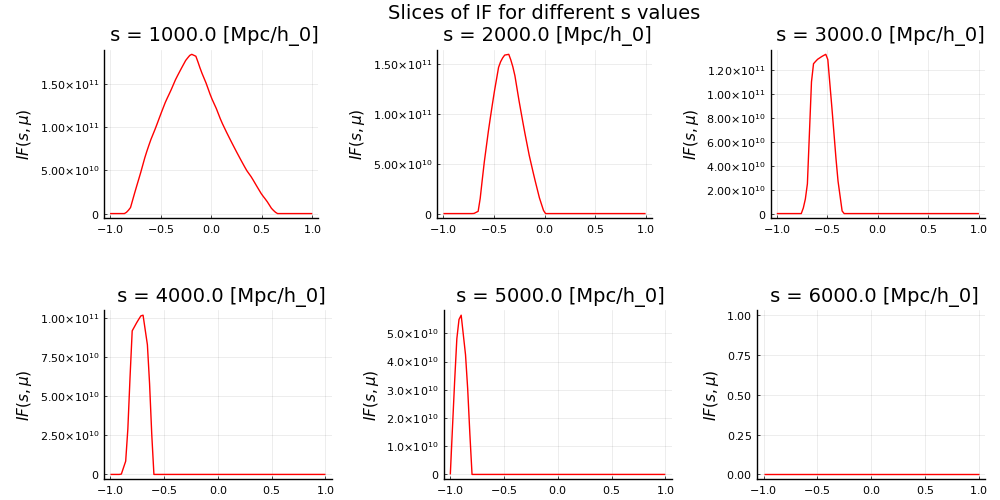

In [96]:
pyplot()

title = plot(title = "Slices of IF for different s values", grid=false, 
    showaxis = false, bottom_margin = -50Plots.px, ticks=false)

θ_max =  π/2.0;
ss = [ i*max(my_Iss...)/6 for i in 1:6];
μs = range(-1.0, 1.0, length=100);

LIST_P = [plot() for i in 1:length(ss)]
for (i,s) in enumerate(ss)
    tit = "\n\n s = $s [Mpc/h_0]"
    xs_1 = μs
    ys_1 = [my_spline_IF(s, μ) for μ in xs_1]

    LIST_P[i] = plot(xs_1, ys_1, 
        #xaxis=:log, yaxis=:log, 
        lc=:red, title=tit, legend=false,
        ylabel=L"IF(s,\mu)", ls=:solid, 
        #xticks=10.0 .^ range(-3,0, step=1),
    )
end

l = @layout [ A{0.003h} ; a b c ; d e f ]
ALL_PLOTS = plot(title, LIST_P..., layout=l,
    left_margins = 15Plots.px, right_margins = 15Plots.px, size=(1000,500))

## Computation of the Matter TPCF and PS, both "pure" and in Plane-Parallel approx

In [97]:
in_file_ps = FILE_PS;
out_xi_matter = DIR*"xi_matter.txt";
out_xi_ppmatter_noF = DIR*"xi_ppmatter_L0_noF.txt";
out_xi_ppmatter_withF = DIR*"xi_ppmatter_L0_withF.txt";

out_ps_matter = DIR*"ps_matter.txt";
out_ps_ppmatter_noF = DIR*"ps_ppmatter_L0_noF.txt";
out_ps_ppmatter_withF = DIR*"ps_ppmatter_L0_withF.txt";

In [115]:
GaPSE.print_ξ_from_PS(in_file_ps, out_xi_matter; 
    int_k_min = 1/(2*cosmo.s_max), int_k_max = 1e1,
     L = 0, N = 1024, pr = true,
     s0 = nothing, right = nothing);

GaPSE.print_PS_multipole(out_xi_matter, out_ps_matter;
     L = 0, N = 1000, pr = true, int_s_min=1e-1, int_s_max=2*cosmo.s_max);


I'm computing the TPCF from the file "../test/datatest/file_pk.txt" 

time needed for this TPCF computation [in s] = 0.0016291141510009766


I'm computing the PS_multipole from the file "Effective_fNL_z115_files/xi_matter.txt" 

time needed for this Power Spectrum computation [in s] = 0.001004934310913086



In [116]:
GaPSE.print_map_ξ_PPMatter_multipole(cosmo, 
    out_xi_ppmatter_noF, 10 .^ range(0,log10(2*cosmo.s_max),length=1000);
    L = 0, use_windows = false, pr = true, enhancer = 1e6,
    N_μs = 200, μ_atol = 0.0, μ_rtol = 1e-2, trap = false);

GaPSE.print_PS_multipole(out_xi_ppmatter_noF, out_ps_ppmatter_noF;
     L = 0, N = 1000, pr = true, int_s_min=1e-1, int_s_max=2*cosmo.s_max);


time needed for map_ξ_PPMatter_multipole [in s] = 0.01083 

I'm computing the PS_multipole from the file "Effective_fNL_z115_files/xi_ppmatter_L0_noF.txt" 

time needed for this Power Spectrum computation [in s] = 0.0021300315856933594



In [117]:
GaPSE.print_map_ξ_PPMatter_multipole(cosmo, 
    out_xi_ppmatter_withF, 10 .^ range(0,log10(2*cosmo.s_max),length=1000);
    L = 0, use_windows = true, pr = true, enhancer = 1e6,
    N_μs = 200, μ_atol = 0.0, μ_rtol = 1e-2, trap = false);

GaPSE.print_PS_multipole(out_xi_ppmatter_withF, out_ps_ppmatter_withF;
     L = 0, N = 1000, pr = true, int_s_min=1e-1, int_s_max=2*cosmo.s_max);

PP Matter, L=0: 100%|███████████████████████████████████| Time: 0:00:02



time needed for map_ξ_PPMatter_multipole [in s] = 2.85410 

I'm computing the PS_multipole from the file "Effective_fNL_z115_files/xi_ppmatter_L0_withF.txt" 

time needed for this Power Spectrum computation [in s] = 0.0013511180877685547



In [118]:
ss_matter, xis_matter = readxy(out_xi_matter);
ss_ppm_noF, xis_ppm_noF = readxy(out_xi_ppmatter_noF);
ss_ppm_withF, xis_ppm_withF = readxy(out_xi_ppmatter_withF);

ks_matter, pks_matter = readxy(out_ps_matter);
ks_ppm_noF, pks_ppm_noF = readxy(out_ps_ppmatter_noF);
ks_ppm_withF, pks_ppm_withF = readxy(out_ps_ppmatter_withF);

## Plots

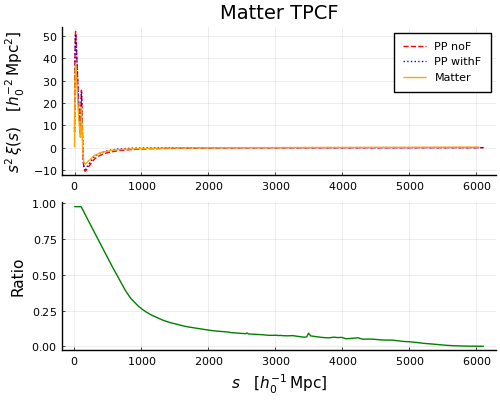

In [119]:
xs_1 = ss_ppm_noF
ys_1 = xis_ppm_noF .* xs_1 .^2

xs_2 = ss_ppm_withF
ys_2 = xis_ppm_withF .* xs_2 .^2
spline = Spline1D(xs_2, ys_2)

xs_3 = ss_matter
ys_3 = xis_matter .* xs_3 .^2

S_VLIM = 8
S_VLIM_F = @sprintf("%.2f", S_VLIM)

p1 = plot([xs_1, xs_2], [ys_1, ys_2],
    #xaxis=:log, yaxis=:log, 
    lc=[:red :blue], 
    title = "Matter TPCF",
    label=["PP noF" "PP withF"], ls=[:dash :dot], 
    ylabel = L"s^2 \, \xi(s) \quad [h_0^{-2} \,\mathrm{Mpc}^{2}]",
    legend=:topright)
plot!(p1, xs_3, ys_3, label = "Matter", ls=:solid, lc =:orange)
#vline!(p1, [S_VLIM], label="$S_VLIM_F Mpc/h_0", lc=:black, lw=0.5, ls=:dash)

p2 = plot(xs_1, spline.(xs_1) ./ ys_1, 
    ylabel="Ratio", lc=:green, 
    #xaxis=:log,
    #ylim=(0.97,1.03), 
    legend=false, 
    xlabel=L"$s \quad [h_0^{-1} \,\mathrm{Mpc}]$")
#vline!(p2, [S_VLIM], label="$S_VLIM_F Mpc/h_0", lc=:black, lw=0.5, ls=:dash)

P = plot(p1, p2, size=(500, 400), layout= @layout [ x ; z ] )
#savefig(P, "PS_AutoDoppler_L0.pdf")
#display(P)

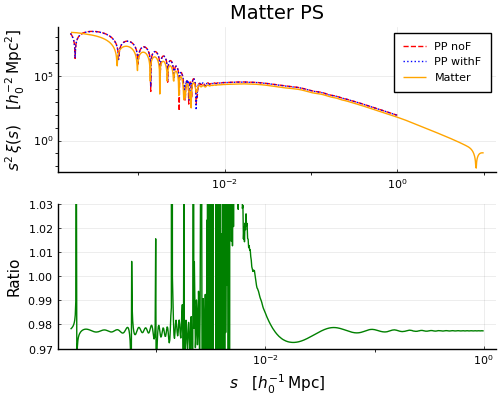

In [121]:
xs_1 = ks_ppm_noF
ys_1 = abs.(pks_ppm_noF)

xs_2 = ks_ppm_withF
ys_2 = abs.(pks_ppm_withF)
spline = Spline1D(xs_2, ys_2)

xs_3 = ks_matter
ys_3 = abs.(pks_matter)

S_VLIM = 8
S_VLIM_F = @sprintf("%.2f", S_VLIM)

p1 = plot([xs_1, xs_2], [ys_1, ys_2],
    xaxis=:log, yaxis=:log, 
    lc=[:red :blue], 
    title = "Matter PS",
    label=["PP noF" "PP withF"], ls=[:dash :dot], 
    ylabel = L"s^2 \, \xi(s) \quad [h_0^{-2} \,\mathrm{Mpc}^{2}]",
    legend=:topright)
plot!(p1, xs_3, ys_3, label = "Matter", ls=:solid, lc =:orange)
#vline!(p1, [S_VLIM], label="$S_VLIM_F Mpc/h_0", lc=:black, lw=0.5, ls=:dash)

p2 = plot(xs_1, spline.(xs_1) ./ ys_1, 
    ylabel="Ratio", lc=:green, 
    xaxis=:log,
    ylim=(0.97,1.03), 
    legend=false, 
    xlabel=L"$s \quad [h_0^{-1} \,\mathrm{Mpc}]$")
#vline!(p2, [S_VLIM], label="$S_VLIM_F Mpc/h_0", lc=:black, lw=0.5, ls=:dash)

P = plot(p1, p2, size=(500, 400), layout= @layout [ x ; z ] )
#savefig(P, "PS_AutoDoppler_L0.pdf")
#display(P)

## All GR effects TPCFs computation (with F)

In [17]:
#=
GaPSE.print_map_sum_ξ_LD_multipole(
    cosmo, DIR*"map_sum_xis_LD_L0_withF.txt", 
    10 .^ range(0, 3, length = 300);
    single = true, use_windows = true, enhancer = 1e8, L=0,
    N_μs = 200, μ_atol = 0.0, μ_rtol = 1e-2, trap = true,
    N_χs = 50, N_χs_2 = 60);
=#

In [18]:
#=
GaPSE.print_map_sum_ξ_GNC_multipole(
    cosmo, DIR*"map_sum_xis_GNC_L0_withF.txt", 
    10 .^ range(0, 3, length = 300);
    single = true, use_windows = true, enhancer = 1e8, L=0,
    N_μs = 200, μ_atol = 0.0, μ_rtol = 1e-2, trap = true,
    N_χs = 100, N_χs_2 = 60);
=#

In [19]:
#=
GaPSE.print_map_sum_ξ_GNCxLD_multipole(
    cosmo, DIR*"map_sum_xis_GNCxLD_L0_withF.txt", 
    10 .^ range(0, 3, length = 300);
    single = true, use_windows = true, enhancer = 1e8, L=0,
    N_μs = 200, μ_atol = 0.0, μ_rtol = 1e-2, trap = true,
    N_χs = 100, N_χs_2 = 60);
=#

In [20]:
#=
GaPSE.print_map_sum_ξ_LDxGNC_multipole(
    cosmo, DIR*"map_sum_xis_LDxGNC_L0_withF.txt", 
    10 .^ range(0, 3, length = 300);
    single = true, use_windows = true, enhancer = 1e8, L=0,
    N_μs = 200, μ_atol = 0.0, μ_rtol = 1e-2, trap = true,
    N_χs = 100, N_χs_2 = 60);
=#

In [21]:
ss_LD, xis_sum_LD, all_xis_LD = readxyall(DIR*"map_sum_xis_LD_L0_withF.txt");
ss_GNC, xis_sum_GNC, all_xis_GNC = readxyall(DIR*"map_sum_xis_GNC_L0_withF.txt");
ss_GNCxLD, xis_sum_GNCxLD, all_xis_GNCxLD = readxyall(DIR*"map_sum_xis_GNCxLD_L0_withF.txt");
ss_LDxGNC, xis_sum_LDxGNC, all_xis_LDxGNC = readxyall(DIR*"map_sum_xis_LDxGNC_L0_withF.txt");

spline_LD_sum = Spline1D(ss_LD, xis_sum_LD; bc = "error");
spline_GNC_sum = Spline1D(ss_GNC, xis_sum_GNC; bc = "error");
spline_GNCxLD_sum = Spline1D(ss_GNCxLD, xis_sum_GNCxLD; bc = "error");
spline_LDxGNC_sum = Spline1D(ss_LDxGNC, xis_sum_LDxGNC; bc = "error");

In [22]:
ss_sum = ss_LD;
xis_sum = [spline_LD_sum(s) + spline_GNC_sum(s) + 
        spline_GNCxLD_sum(s) + spline_LDxGNC_sum(s)
        for s in ss_sum];

open(DIR*"xi_ALL_GR_TPCF_SUMMED.txt", "w") do io
    println(io, GaPSE.BRAND)
    println(io, "# This is the sum of all the GR effects TPCFs:")
    println(io, "# LD (16), GNC (25), GNCxLD (20), LDxGNC (20)\n#")
    GaPSE.parameters_used(io, cosmo; logo=false)
    println(io, "# s [Mpc/h_0] \t xi_ALLSUMMED")
    for (s,xi) in zip(ss_sum, xis_sum)
        println(io, "$s \t $xi")
    end
end

GaPSE.print_PS_multipole(DIR*"xi_ALL_GR_TPCF_SUMMED.txt", 
    DIR*"ps_ALL_GR_TPCF_SUMMED.txt"; 
    L = 0, N = 1000, pr = true, 
    int_s_min=1e-1, int_s_max=1e3);


I'm computing the PS_multipole from the file "Effective_fNL_z115_files/xi_ALL_GR_TPCF_SUMMED.txt" 

time needed for this Power Spectrum computation [in s] = 0.0006520748138427734



In [23]:
ks_sum, pks_sum = readxy(DIR*"ps_ALL_GR_TPCF_SUMMED.txt");

## Plots

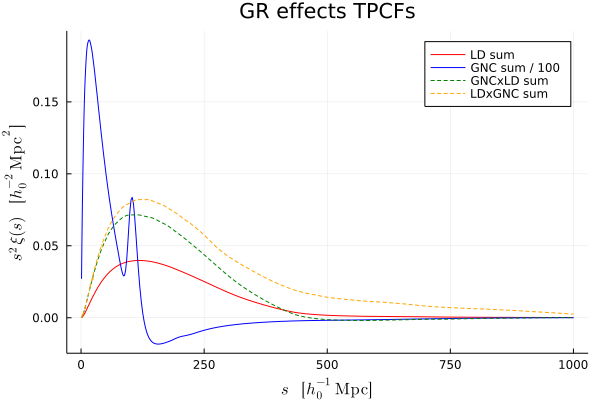

In [24]:
xs_1 = ss_LD
ys_1 = xis_sum_LD .* xs_1 .^2

xs_2 = ss_GNC
ys_2 = xis_sum_GNC .* xs_2 .^2 ./100

xs_3 = ss_GNCxLD
ys_3 = xis_sum_GNCxLD .* xs_3 .^2

xs_4 = ss_LDxGNC
ys_4 = xis_sum_LDxGNC .* xs_4 .^2

S_VLIM = 8
S_VLIM_F = @sprintf("%.2f", S_VLIM)

p1 = plot(xs_1, ys_1,
    #xaxis=:log, yaxis=:log, 
    lc=:red, title = "GR effects TPCFs", #ylims =(-0.11, 0.31),
    label="LD sum", ls=:solid, legend=:topright,
    ylabel = L"s^2 \, \xi(s) \quad [h_0^{-2} \,\mathrm{Mpc}^{2}]",
    xlabel = L"$s \quad [h_0^{-1} \,\mathrm{Mpc}]$")
plot!(p1, xs_2, ys_2, label = "GNC sum / 100", ls=:solid, lc =:blue)
plot!(p1, xs_3, ys_3, label = "GNCxLD sum", ls=:dash, lc =:green)
plot!(p1, xs_4, ys_4, label = "LDxGNC sum", ls=:dash, lc =:orange)
#vline!(p1, [S_VLIM], label="$S_VLIM_F Mpc/h_0", lc=:black, lw=0.5, ls=:dash)

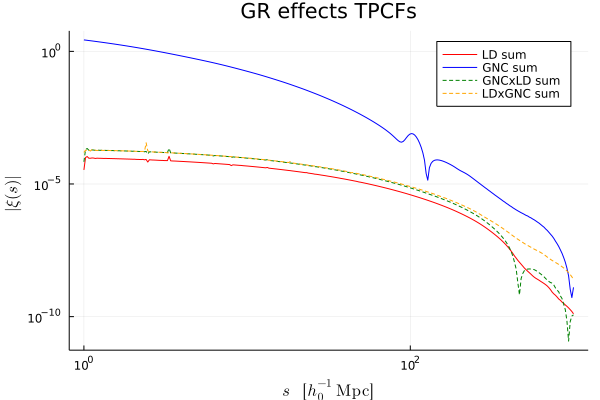

In [25]:
xs_1 = ss_LD
ys_1 = abs.(xis_sum_LD)

xs_2 = ss_GNC
ys_2 = abs.(xis_sum_GNC)

xs_3 = ss_GNCxLD
ys_3 = abs.(xis_sum_GNCxLD)

xs_4 = ss_LDxGNC
ys_4 = abs.(xis_sum_LDxGNC)

S_VLIM = 8
S_VLIM_F = @sprintf("%.2f", S_VLIM)

p1 = plot(xs_1, ys_1,
    xaxis=:log, yaxis=:log, 
    lc=:red, title = "GR effects TPCFs", #ylims =(-0.11, 0.31),
    label="LD sum", ls=:solid, legend=:topright,
    ylabel = L"|\xi(s)| ",
    xlabel = L"$s \quad [h_0^{-1} \,\mathrm{Mpc}]$")
plot!(p1, xs_2, ys_2, label = "GNC sum", ls=:solid, lc =:blue)
plot!(p1, xs_3, ys_3, label = "GNCxLD sum", ls=:dash, lc =:green)
plot!(p1, xs_4, ys_4, label = "LDxGNC sum", ls=:dash, lc =:orange)
#vline!(p1, [S_VLIM], label="$S_VLIM_F Mpc/h_0", lc=:black, lw=0.5, ls=:dash)

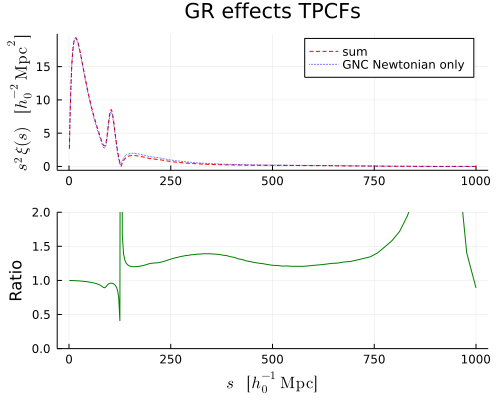

In [26]:
xs_1 = ss_sum
ys_1 = abs.(xis_sum .* xs_1 .^2)

xs_2 = ss_GNC
ys_2 = abs.(all_xis_GNC[1] .* xs_2 .^2)
spline = Spline1D(xs_2, ys_2)

S_VLIM = 8
S_VLIM_F = @sprintf("%.2f", S_VLIM)

p1 = plot([xs_1, xs_2], [ys_1, ys_2],
    #xaxis=:log, yaxis=:log, 
    lc=[:red :blue], 
    title = "GR effects TPCFs",
    label=["sum" "GNC Newtonian only"], ls=[:dash :dot], 
    ylabel = L"s^2 \, \xi(s) \quad [h_0^{-2} \,\mathrm{Mpc}^{2}]",
    legend=:topright)
#vline!(p1, [S_VLIM], label="$S_VLIM_F Mpc/h_0", lc=:black, lw=0.5, ls=:dash)

p2 = plot(xs_1, spline.(xs_1) ./ ys_1, 
    ylabel="Ratio", lc=:green, 
    #xaxis=:log,
    ylim=(0.0,2), 
    legend=false, 
    xlabel=L"$s \quad [h_0^{-1} \,\mathrm{Mpc}]$")
#vline!(p2, [S_VLIM], label="$S_VLIM_F Mpc/h_0", lc=:black, lw=0.5, ls=:dash)

P = plot(p1, p2, size=(500, 400), layout= @layout [ x ; z ] )
#savefig(P, "PS_AutoDoppler_L0.pdf")
#display(P)

## f_NL

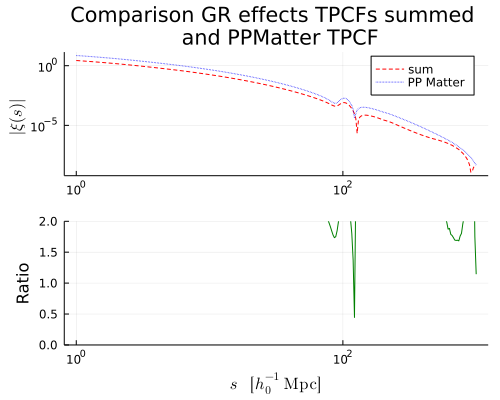

In [27]:
xs_1 = ss_sum
ys_1 = abs.(xis_sum)

xs_2 = ss_ppm_withF
ys_2 = abs.(xis_ppm_withF)
spline = Spline1D(xs_2, ys_2)

S_VLIM = 8
S_VLIM_F = @sprintf("%.2f", S_VLIM)

p1 = plot([xs_1, xs_2], [ys_1, ys_2],
    xaxis=:log, yaxis=:log, 
    lc=[:red :blue], 
    title = "Comparison GR effects TPCFs summed \n and PPMatter TPCF",
    label=["sum" "PP Matter"], ls=[:dash :dot], 
    ylabel = L"|\xi(s)|",
    legend=:topright)
#vline!(p1, [S_VLIM], label="$S_VLIM_F Mpc/h_0", lc=:black, lw=0.5, ls=:dash)

p2 = plot(xs_1, spline.(xs_1) ./ ys_1, 
    ylabel="Ratio", lc=:green, 
    xaxis=:log,
    ylim=(0.0,2), 
    legend=false, 
    xlabel=L"$s \quad [h_0^{-1} \,\mathrm{Mpc}]$")
#vline!(p2, [S_VLIM], label="$S_VLIM_F Mpc/h_0", lc=:black, lw=0.5, ls=:dash)

P = plot(p1, p2, size=(500, 400), layout= @layout [ x ; z ] )
#savefig(P, "PS_AutoDoppler_L0.pdf")
#display(P)

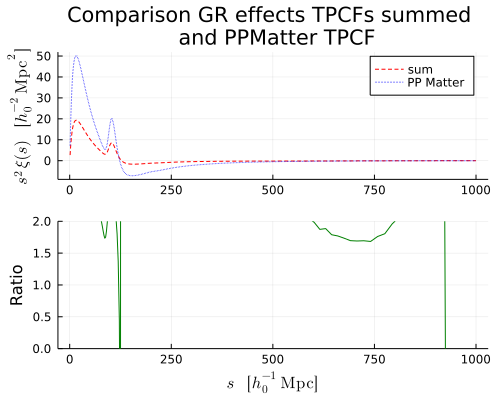

In [28]:
xs_1 = ss_sum
ys_1 = xis_sum .* xs_1 .^ 2

xs_2 = ss_ppm_withF
ys_2 = xis_ppm_withF .* xs_2 .^ 2
spline = Spline1D(xs_2, ys_2)

S_VLIM = 8
S_VLIM_F = @sprintf("%.2f", S_VLIM)

p1 = plot([xs_1, xs_2], [ys_1, ys_2],
    #xaxis=:log, yaxis=:log, 
    lc=[:red :blue], 
    title = "Comparison GR effects TPCFs summed \n and PPMatter TPCF",
    label=["sum" "PP Matter"], ls=[:dash :dot], 
    ylabel = L"s^2 \, \xi(s) \quad [h_0^{-2} \,\mathrm{Mpc}^{2}]",
    legend=:topright)
#vline!(p1, [S_VLIM], label="$S_VLIM_F Mpc/h_0", lc=:black, lw=0.5, ls=:dash)

p2 = plot(xs_1, spline.(xs_1) ./ ys_1, 
    ylabel="Ratio", lc=:green, 
    #xaxis=:log,
    ylim=(0.0,2), 
    legend=false, 
    xlabel=L"$s \quad [h_0^{-1} \,\mathrm{Mpc}]$")
#vline!(p2, [S_VLIM], label="$S_VLIM_F Mpc/h_0", lc=:black, lw=0.5, ls=:dash)

P = plot(p1, p2, size=(500, 400), layout= @layout [ x ; z ] )
#savefig(P, "PS_AutoDoppler_L0.pdf")
#display(P)

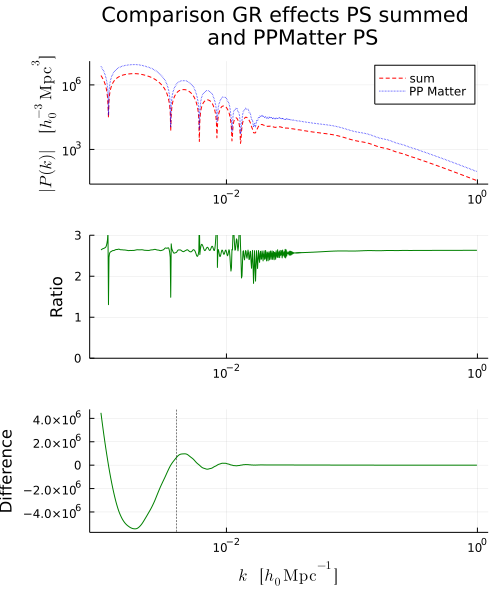

In [29]:
xs_1 = ks_sum
ys_1 = pks_sum

xs_2 = ks_ppm_withF
ys_2 = pks_ppm_withF
spline = Spline1D(xs_2, ys_2)

S_VLIM = 8
S_VLIM_F = @sprintf("%.2f", S_VLIM)

p1 = plot([xs_1, xs_2], [abs.(ys_1), abs.(ys_2)],
    xaxis=:log, yaxis=:log, 
    lc=[:red :blue], 
    title = "Comparison GR effects PS summed \n and PPMatter PS",
    label=["sum" "PP Matter"], ls=[:dash :dot], 
    ylabel = L"|P(k)| \quad [h_0^{-3}\,\mathrm{Mpc}^3]",
    legend=:topright)
#vline!(p1, [S_VLIM], label="$S_VLIM_F Mpc/h_0", lc=:black, lw=0.5, ls=:dash)

p2 = plot(xs_1, spline.(xs_1) ./ ys_1, 
    ylabel="Ratio", lc=:green, 
    xaxis=:log,
    ylim=(0.0,3), 
    legend=false, 
    #xlabel=L"$k \quad [h_0 \,\mathrm{Mpc}^{-1}]$",
    )
#vline!(p2, [S_VLIM], label="$S_VLIM_F Mpc/h_0", lc=:black, lw=0.5, ls=:dash)

p3 = plot(xs_1, spline.(xs_1) .- ys_1, 
    ylabel="Difference", lc=:green, 
    xaxis=:log,
    #ylim=(0.0,2), 
    legend=false, 
    xlabel=L"$k \quad [h_0 \,\mathrm{Mpc}^{-1}]$")
VAXES = 4e-3
vline!(p3, [VAXES], label="$VAXES Mpc/h_0", lc=:black, lw=0.5, ls=:dash)

P = plot(p1, p2, p3, size=(500, 600), layout= @layout [ x ; y ; z ] )
savefig(P, "PS_sum-matter.pdf")
display(P)

In [30]:
spline = Spline1D(ks_ppm_withF, pks_ppm_withF; bc = "error");
difference = [spline(k) - pk for (k,pk) in zip(ks_sum, pks_sum)];

In [31]:
f(x; a=1.0, b=1.0, c=1.0) = c + b*x + a*x^2;

In [32]:
LIM = 1.5e-3
c,b,a = GaPSE.polynomial_from_data(ks_sum, difference, [1.0, 1.0, 1.0], ks_sum[begin], LIM)

3 params, all sigmas_r ok


(3.173806680755772e13, -9.724699867166391e10, 6.98560349119233e7)

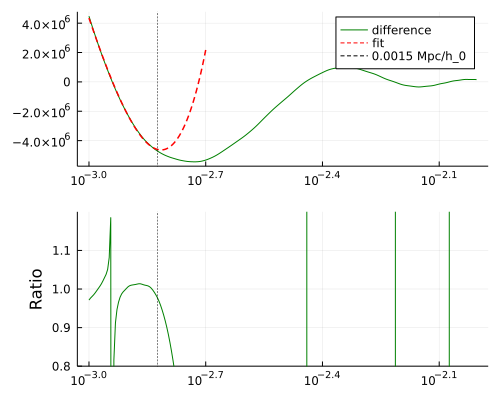

In [33]:
xs_1 = ks_sum[ks_sum .< 1e-2]
xs_2 = ks_sum[ks_sum .< 2e-3]
ys_1 = difference[ks_sum .< 1e-2]
ys_2 = [GaPSE.polynomial(x,c,b,a) for x in ks_sum[ks_sum .< 2e-3]]
spline = Spline1D(xs_2, ys_2; bc ="nearest")

p1 = plot(xs_1, ys_1, xaxis=:log, color=:green, label="difference")
ys = [f(k; a = 1e10, b = 1e8, c = 1.0) for k in ks_sum[ks_sum .< 5e-3]];
plot!(p1, xs_2, ys_2,
    color = :red, ls=:dash, lw=1.5, label="fit")
vline!(p1, [LIM], label="$LIM Mpc/h_0", lc=:black, lw=0.5, ls=:dash)

p2 = plot(xs_1, spline.(xs_1) ./ ys_1, 
    ylabel="Ratio", lc=:green, 
    xaxis=:log,
    ylim=(0.8,1.2), 
    legend=false, 
    #xlabel=L"$k \quad [h_0 \,\mathrm{Mpc}^{-1}]$",
    )
vline!(p2, [LIM], label="$LIM Mpc/h_0", lc=:black, lw=0.5, ls=:dash)

plot(p1, p2,  size=(500, 400), layout= @layout [ x ; y ] )

In [34]:
function chi_square(ys_expected, ys_observed)
    sum([(o-e)^2/e for (o,e) in zip(ys_observed,ys_expected)])
end

chi_square (generic function with 1 method)

In [35]:
chi_square(difference[ks_sum .< LIM], [GaPSE.polynomial(x,c,b,a) for x in ks_sum[ks_sum .< LIM]])

-270111.45852284966

In [36]:
?LogUniform

search: LogUniform



```
LogUniform(a,b)
```

A positive random variable `X` is log-uniformly with parameters `a` and `b` if the logarithm of `X` is `Uniform(log(a), log(b))`. The *log uniform* distribution is also known as *reciprocal distribution*.

```julia
LogUniform(1,10)
```

External links

  * [Log uniform distribution on Wikipedia](https://en.wikipedia.org/wiki/Reciprocal_distribution)


In [37]:
plot(xs, ys)

LoadError: UndefVarError: xs not defined

In [38]:
pyplot()

# Define a simple Normal model with unknown mean and variance.
@model function demo_polyn(x, y)
    a ~ Uniform(-1e3, 1e3)
    b ~ Uniform(-1e3, 1e3)
    c ~ Uniform(-1e3, 1e3)
    s² ~ Uniform(0, 10)
    m ~ Uniform(-10, 10)
    d = y .- (a .+ b .* x .+ c.*x.^2)
    d ~  Normal(m, s²)
end

#  Run sampler, collect results
xs = ks_sum[ks_sum.<LIM]
ys = difference[ks_sum .< LIM] ./ 1e6
chn = sample(demo_polyn(xs, ys), HMC(0.1, 5), 1000)

# Summarise results
summaries, quantiles = describe(chn);

Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00


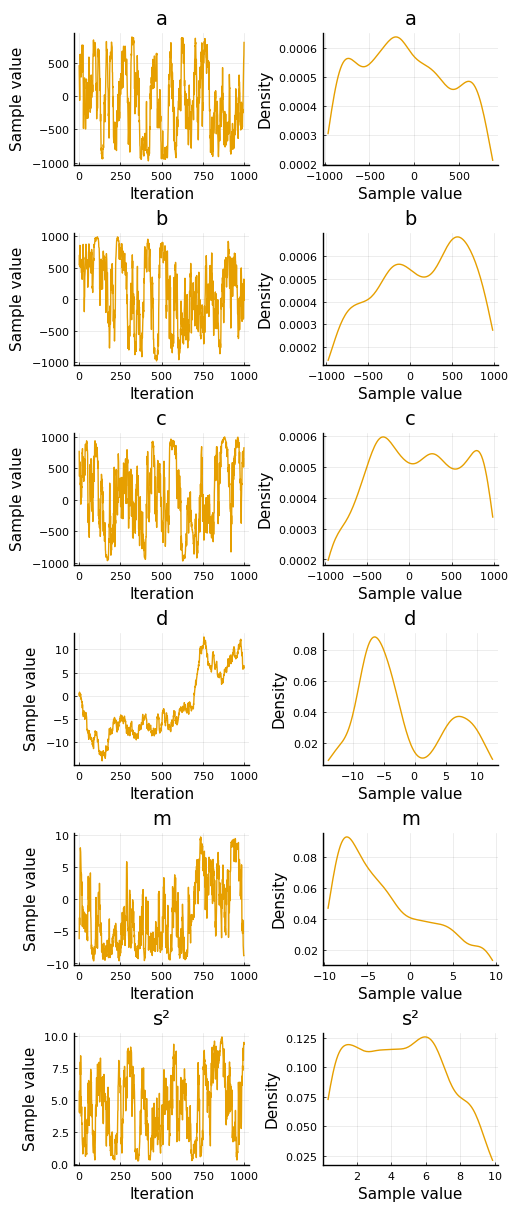

In [39]:
# Plot and save results
p = plot(chn, size=(500, 1200))
savefig("gdemo-plot.png")
#display(p)